# Current SARS-CoV-2 Viral Diversity Supports Transmission Rule-Out by Genomic Sequencing



When community transmission levels are high, there will be many coincidences in which individuals in the same workplace, classroom, nursing home, or other institution test positive for SARS-CoV-2 purely by chance. Genomic sequencing can separate such coincidences from true transmission clusters.

Demonstrating that an epidemiologically-linked cluster does not have genomic links provides reassurance to stakeholders that infection control practices are working. If an epidemiologically-linked cluster does have genomic links, transmission in the identified setting is more likely and decision-makers can focus on revising infection control practices or policies to prevent future transmission.

This is possible because the SARS-CoV-2 virus mutates, on average, once every 2 weeks. (See [nextstrain](https://nextstrain.org/ncov/gisaid/global?l=clock) for an up-to-date estimate. As of 10-01-21, the rate estimate was 23.87 substitutions per year, or one every 2.18 weeks.) If two people are part of the same transmission event (A infected B, or some C infected both A and B), then the genome sequences of the virus from each case involved will differ by at most 1 or 2 mutations.

![Nextstrain Clock Rate](img/nextstrain_clock.png)


The converse is not necessarily true: it is possible for the genomes of virus to match even when the cases are epidemiologically quite distant, especially when superspreader events are involved. (Early in the pandemic we [documented](https://twitter.com/thebasepoint/status/1278057767983448064) instances where a viral genomic sequence was observed identically across dozens of countries, and persisted for months.)

Inspired by a potential program doing sequencing in schools, we asked: at this point in the pandemic, how sensitive is genomic sequencing for ruling out transmission? If two cases are unrelated, if the epi link is a coincidence, will genomic sequencing tell you that?

The more diverse the circulating population of SARS-CoV-2, the more powerful sequencing will be.

### Analysis

To answer this question, we picked an American city with a very high level of genomic sequencing being done: San Diego, California. The [SEARCH Alliance](https://searchcovid.info/) has been sequencing SARS-CoV-2 for almost a year and a half, and over the summer, they regularly sequenced 10-20% of the reported daily cases. We chose to analyze samples from August 2021, because it is after the Delta sweep, and so represents the current pandemic phase, and has a large number of genomes already sequenced and deposited into GISAID.

We downloaded the 2429 high-quality genomes from August 2021 from GISAID, and computed their pairwise SNP distances using `snp-dists` on a `mafft` alignment.

![SEARCH Alliance](img/GISAID_download.png)

We define a *potential coincidental epi link* to be a pair of samples from the time period, with collection dates less than 2 weeks apart. We say that potential epi link would be ruled out if the genomes are more than 2 SNPs away from each other.

**We find that 99.5% of potential spurious epi links would be ruled out by sequencing!**

One way to think about this: a given person A was infected by one person B. Just 0.5% of the cases in the area have genotypes close enough to that of A to plausibly be the infector B, so the chances that a coincidentally epi-linked case is also a genetic link is very low.

Analysis below:

In [1]:
# Inputs
fasta_file = 'data/1633204764832.sequences.fasta'
meta_file = 'data/1633204764832.metadata.tsv'
reference_file = 'data/ref.fasta'

In [35]:
# Intermediates
working_dir = 'scratch/'
aligned_file = working_dir + 'aligned.aln'
aligned_masked_file = working_dir + 'aligned_masked.aln'
dists_file = working_dir + 'snp-dists.tsv'
dists_masked_file = working_dir + 'snp-dists_masked.tsv'

Align whole genomes to reference.

In [3]:
# Flags just align to reference
!mafft  \
    --6merpair --thread 10 --keeplength --addfragments  \
    {fasta_file} {reference_file} > {aligned_file}

nadd = 3830
ppenalty_ex = -10
nthread = 10
blosum 62 / kimura 200
sueff_global = 0.100000
norg = 1
njobc = 2
generating a scoring matrix for nucleotide (dist=200) ... done


Making a distance matrix ..

There are 338311 ambiguous characters
    1 / 1 (thread    0)
done.

fTEP 499 / 3830 (thread 4)                    
STEP 500 / 3830 (thread 5)                    
ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
STEP 600 / 3830 (thread 1)                    
ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
STEP 700 / 3830 (thread 8)                    
ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
STEP 800 / 3830 (thread 0)                    
ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff
STEP 900 / 3830 (thread 9)                    
ffffffffffffffffffffffffffffffffffffffffff

Mask sites

In [25]:
import pandas as pd
from Bio import AlignIO
import copy

algn = AlignIO.read(aligned_file, "fasta")

In [33]:
masked_algn = copy.deepcopy(algn) # Create copy to test differences
masked_vcf_url = "https://raw.githubusercontent.com/W-L/ProblematicSites_SARS-CoV2/master/problematic_sites_sarsCov2.vcf"
masked_vcf = pd.read_csv(masked_vcf_url, sep="\t", comment="#", names=["region", "pos", "ref", "alt", "x", "y", "mask", "comment"])
masked_sites = masked_vcf[masked_vcf["mask"] == "mask"]["pos"].tolist()

for i in masked_sites:
    pos = i-1
    for rec in masked_algn:
        rec.seq = rec.seq[:pos] + "N" + rec.seq[pos+1:]

AlignIO.write(masked_algn, aligned_masked_file, "fasta")

1

Compute SNP distances between samples.

In [40]:
!/home/gk/code/snp-dists/snp-dists -j 20 \
-m {aligned_file} > {dists_file}

This is snp-dists 0.8.2
Will use 20 threads.
Read 3831 sequences of length 29903


In [41]:
!/home/gk/code/snp-dists/snp-dists -j 20 \
-m {aligned_masked_file} > {dists_masked_file}

This is snp-dists 0.8.2
Will use 20 threads.
Read 3831 sequences of length 29903


In [17]:
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tqdm
import seaborn as sns
%matplotlib inline

In [4]:
# Load metadata
meta = pd.read_csv(meta_file, sep='\t')
date_lookup = dict()
for sample, date in zip(meta['strain'], meta['date']):
    if pd.isna(date):
        print(f"Warning: {sample} is missing collection date.")
        date_lookup[sample] = np.nan
    else:
        date_lookup[sample] = datetime.datetime.strptime(date, '%Y-%m-%d').toordinal()

In [18]:
# Close = SNP dist <= 2, Far = SNP dist > 2, for samples collected 
# within 2 weeks of each other
def compute_pairs(dist_matrix_file):
    close_pairs = 0
    far_pairs = 0
    distances = []
    with open(dist_matrix_file, 'r') as infile:
        for line in tqdm.tqdm(infile):
            (sample1, sample2, distance) = line.split()
            distance = int(distance)
            if sample1 not in date_lookup or sample2 not in date_lookup:
                continue
            if abs(date_lookup[sample1] - date_lookup[sample2]) > 14:
                continue
            if sample1 == sample2:
                continue
            if distance <= 2:
                close_pairs += 1
            if distance > 2:
                far_pairs += 1
            distances.append(distance)
        return close_pairs, far_pairs, distances

In [55]:
close_pairs, far_pairs, distances = compute_pairs(dists_file)
close_pairs, far_pairs
np.round(100*far_pairs/(close_pairs + far_pairs), 1)

14676561it [00:19, 756204.39it/s]


99.5

In [56]:
masked_close_pairs, masked_far_pairs, masked_distances = compute_pairs(dists_masked_file)
masked_close_pairs, masked_far_pairs
np.round(100*masked_far_pairs/(masked_close_pairs + masked_far_pairs), 1)

14676561it [00:19, 761674.08it/s]


99.5

In [22]:
masked_close_pairs, masked_far_pairs

(56012, 11129644)

In [23]:
close_pairs, far_pairs

(52722, 11132934)

## Measuring Diversity Within and Between Lineages

A more detailed histogram of all pairwise SNP distances between samples collected within 2 weeks of one another shows a tri-modal plot.

Only pairs of samples on the far left (to the left of the 2-SNP red line) could have direct transmission links.

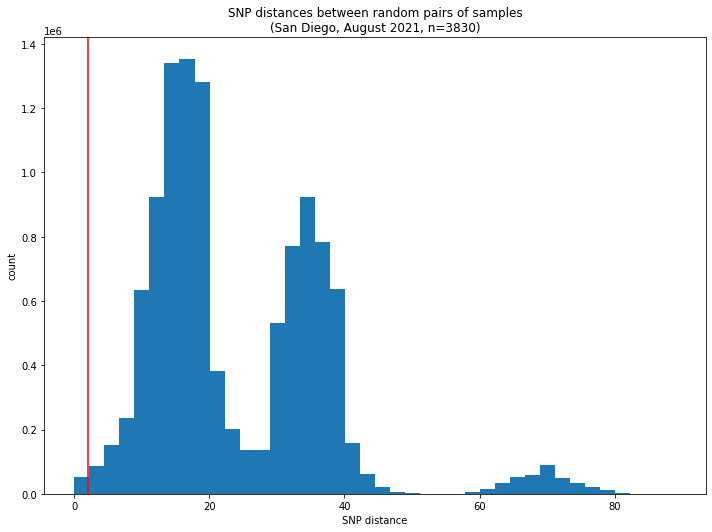

In [57]:
plt.subplots(figsize=(10,7.5))
plt.hist(distances, bins = 40)
plt.title("SNP distances between random pairs of samples\n(San Diego, August 2021, n=3830)")
plt.xlabel('SNP distance')
plt.ylabel('count')
plt.axvline(2, color='red')
plt.tight_layout()
plt.savefig('SNP-dist-san-diego.png')

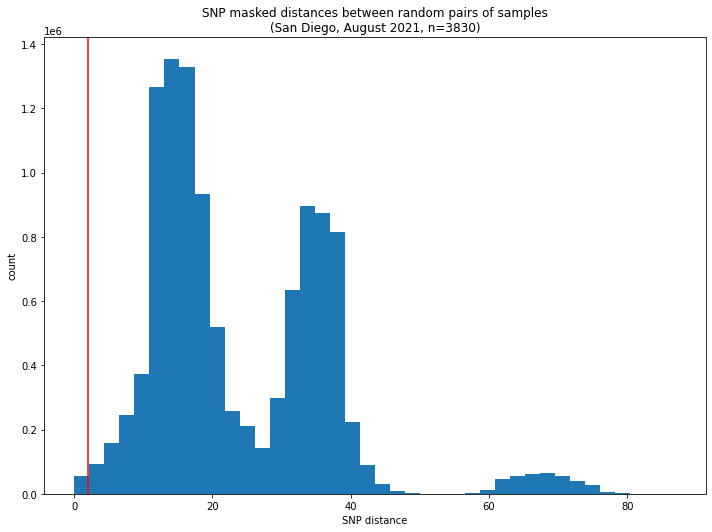

In [58]:
plt.subplots(figsize=(10,7.5))
plt.hist(masked_distances, bins = 40)
plt.title("SNP masked distances between random pairs of samples\n(San Diego, August 2021, n=3830)")
plt.xlabel('SNP distance')
plt.ylabel('count')
plt.axvline(2, color='red')
plt.tight_layout()
plt.savefig('SNP-dist-masked-san-diego.png')

We then investigated the source of the three peaks for pairwise SNP distances: around 15, 35, and 70.

Presumably, these are generated by the typical distances within or between certain lineages. For example, the founding genotypes of  B.1.617.2 and P.1 (Delta and Gamma) are some distance apart on the tree, and the distance from any Delta to any Gamma should be approximately the same. (With a mutation rate of ~1 mut/2 weeks, the distance should be approximately the number of weeks since Delta and Gamma diverged.)

In [26]:
meta.groupby('pangolin_lineage')['date'].count().sort_values(ascending=False)

pangolin_lineage
B.1.617.2    2203
AY.25         550
AY.26         371
AY.20         194
AY.3          137
AY.14         114
AY.13          54
AY.2           52
AY.4           38
P.1            29
AY.3.1         11
AY.33          10
B.1.1.7         8
AY.37           8
B.1.621         7
B.1.628         7
AY.35           6
AY.1            6
P.1.7           5
AY.5            5
P.1.12          3
B.1             2
None            1
B.1.621.1       1
A.2.5           1
B.1.429         1
B.1.1           1
AY.36           1
AY.24           1
AY.21           1
AY.16           1
Q.3             1
Name: date, dtype: int64

In [60]:
lineages = meta['pangolin_lineage'].unique()
n_lineages = len(lineages)

lin_to_row = dict(zip(lineages, range(n_lineages)))
sample_to_lin = dict(zip(meta['strain'], meta['pangolin_lineage']))

counts = np.zeros((n_lineages, n_lineages))
distances = np.zeros((n_lineages, n_lineages))
with open(dists_file, 'r') as infile:
    for line in tqdm.tqdm(infile):
        (sample1, sample2, distance) = line.split()
        if sample1 == sample2:
            continue
        distance = int(distance)
        if sample1 not in date_lookup or sample2 not in date_lookup:
            continue
        if abs(date_lookup[sample1] - date_lookup[sample2]) > 14:
            continue
        lin1 = sample_to_lin[sample1]
        lin2 = sample_to_lin[sample2]
#         distances.loc[lin1, lin2] += distance
#         counts.loc[lin1, lin2] += 1
        idx1 = lin_to_row[lin1]
        idx2 = lin_to_row[lin2]
        distances[idx1, idx2] += distance
        counts[idx1, idx2] += 1
distances = pd.DataFrame(index = lineages,
             columns = lineages,
             data = distances)
counts = pd.DataFrame(index = lineages,
             columns = lineages,
             data = counts)
mean_distances = distances/counts

14676561it [00:42, 343107.08it/s]


Remove None (uncalled lineages), and AY.10 (few pairs w/in 2 week window).

In [61]:
md = mean_distances.drop(['None'], axis = 0).drop(['None'], axis = 1)

In [62]:
within_lineage_dist = (
    md
    .stack()
    .reset_index()
    .query('level_0 == level_1')
    .sort_values(0)
)

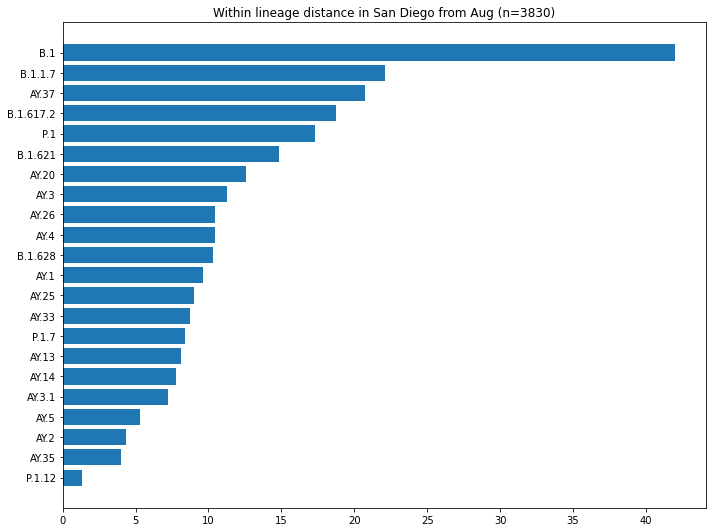

In [63]:
plt.subplots(figsize=(10,7.5))
plt.barh(within_lineage_dist["level_0"].tolist(), within_lineage_dist[0].tolist())
plt.title("Within lineage distance in San Diego from Aug (n=3830)")
plt.tight_layout()
plt.savefig("within_lineage_dist.png", dpi = 300)

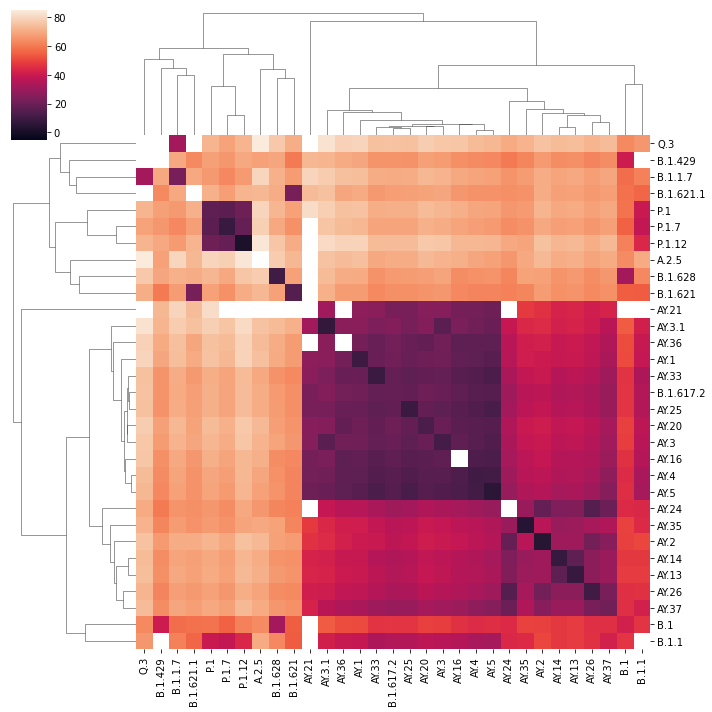

In [64]:
sns.clustermap(md.fillna(0), vmin=-5, mask=md.isna())

The distance between a typical Delta lineage (say, AY.25) and Gamma (P.1) is 71 SNPs. The lineages diverged in Jan 2020, or 86 weeks before these samples were collected.

In [65]:
mean_distances.loc['AY.25', 'P.1']

71.01082580298828

In contrast, the average distance between AY.3 and AY.25 samples is 16.6, which have a least common ancestor in April 2021, or 16 weeks before the samples were collected.

In [66]:
mean_distances.loc['AY.25', 'AY.3']

16.94396099811281

Even within PANGO lineages, there is significant diversity. The average distance within AY.25 is 8, meaning that most pairs could still be ruled out.

In [67]:
mean_distances.loc['AY.25', 'AY.25']

9.015280403276623

Inside Delta more broadly, those still categorized as `B.1.617.2`, the diversity is even greater.

In [70]:
mean_distances.loc['B.1.617.2', 'B.1.617.2']

18.742314467798483

In [95]:
within_lineage_data = []
within_lineage_distances = []
lineage_distribution = {}
with open(dists_file, 'r') as infile:
    for line in tqdm.tqdm(infile):
        (sample1, sample2, distance) = line.split()
        if sample1 == sample2:
            continue
        distance = int(distance)
        if sample1 not in date_lookup or sample2 not in date_lookup:
            continue
        if abs(date_lookup[sample1] - date_lookup[sample2]) > 14:
            continue
        lin1 = sample_to_lin[sample1]
        lin2 = sample_to_lin[sample2]
        row = [sample1, sample2, lin1, lin2, distance]
        within_lineage_data.append(row)
        if lin1 == lin2:
            within_lineage_distances.append(distance)
            if lin1 in lineage_distribution:
                lineage_distribution[lin1].append(distance)
            else:
                lineage_distribution[lin1] = [distance]
                
within_lineage_df = pd.DataFrame(within_lineage_data, columns = ["sample1", "sample2", "sample1_lineage", "sample2_lineage", "snp_distance"])

14676561it [00:37, 387351.94it/s]


In [71]:
(np.array(within_lineage_distances) > 2).sum()/len(within_lineage_distances)

0.9873443214512118

Even if we restrict ourselves to pairs of samples within the same PANGO lineage, 98.5% of samples are still more than 2 SNPs away.

This means that **for transmission cluster rule-out, it is essential to use actual SNP distances, and not just PANGO lineage assignments**. Relying on lineage assignments alone gives up substantial power.

In [72]:
lineage_match = 0
lineage_mismatch = 0
with open(dists_file, 'r') as infile:
    for line in tqdm.tqdm(infile):
        (sample1, sample2, distance) = line.split()
        if sample1 == sample2:
            continue
        distance = int(distance)
        if sample1 not in date_lookup or sample2 not in date_lookup:
            continue
        if abs(date_lookup[sample1] - date_lookup[sample2]) > 14:
            continue
        lin1 = sample_to_lin[sample1]
        lin2 = sample_to_lin[sample2]
        if lin1 == lin2:
            lineage_match += 1
        else:
            lineage_mismatch += 1

14676561it [00:24, 602041.90it/s]


In [73]:
100 - np.round(lineage_mismatch/(lineage_match + lineage_mismatch)*100,2)

36.67

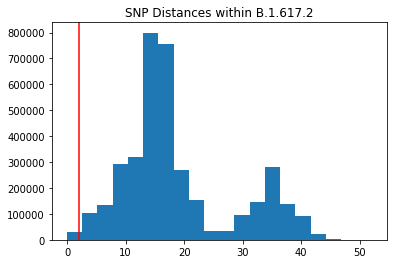

In [74]:
# Within lineage distances
plt.hist(lineage_distribution['B.1.617.2'], bins=20)
plt.title("SNP Distances within B.1.617.2")
plt.axvline(2, color='red')

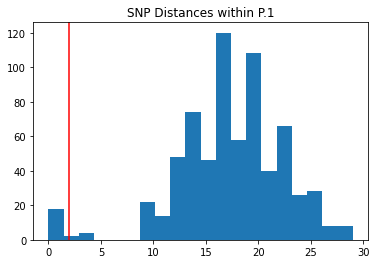

In [75]:
plt.hist(lineage_distribution['P.1'], bins=20)
plt.title("SNP Distances within P.1")
plt.axvline(2, color='red')

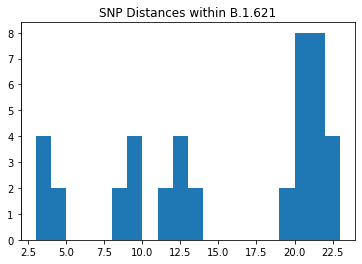

In [23]:
# Within lineage distances
plt.hist(lineage_distribution['B.1.621'], bins=20)
plt.title("SNP Distances within B.1.621")
plt.axvline(2, color='red')

(array([1.47600e+04, 4.54100e+04, 5.91420e+04, 1.25754e+05, 1.45540e+05,
        3.43344e+05, 2.11290e+05, 1.67816e+05, 3.80640e+04, 1.92040e+04,
        1.33240e+04, 2.47120e+04, 9.47840e+04, 8.19640e+04, 8.46780e+04,
        2.41180e+04, 1.14140e+04, 1.58600e+03, 3.80000e+02, 2.40000e+01]),
 array([ 0.  ,  2.55,  5.1 ,  7.65, 10.2 , 12.75, 15.3 , 17.85, 20.4 ,
        22.95, 25.5 , 28.05, 30.6 , 33.15, 35.7 , 38.25, 40.8 , 43.35,
        45.9 , 48.45, 51.  ]),
 <a list of 20 Patch objects>)

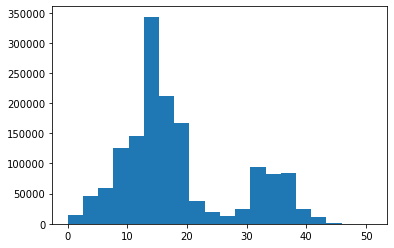

In [24]:
plt.hist(lineage_distribution['B.1.617.2'], bins=20)

## Rule-in?

How reliable is genetic confirmation of an epi link?

We can think of this in a Bayesian way:

$$P(\textrm{transmission}| \textrm{epi}, \textrm{genomics}) = \frac{P(\textrm{genomics}| \textrm{epi}, \textrm{transmission})*P(\textrm{transmission} | \textrm{epi})}{P(\textrm{genomics}|\textrm{epi})}.$$

The probability of seeing a genomic link (<= 2 SNPs) given transmission is very high, say 99% (the 1% accounts for a burst of mutations, as in a long latent infection, or sample mixups in the sequencing lab).

The prior probability of seeing transmission given the epi link alone, $P(\textrm{transmission} | \textrm{epi})$ depends on the circumstance, but might reasonably range from 1% (same school but no shared classes) to 90% (same household).

The denominator is a sum of two terms: the probability of seeing a genomic link given transmission, weighted by the prior probability of transmission given the epi data, plus the probability of seeing a genomic link given no transmission, weighted by the prior probability of no transmission given the epi data.

$$P(\textrm{genomics}|\textrm{epi}) = P(\textrm{genomics}| \textrm{epi}, \textrm{transmission})*P(\textrm{transmission} | \textrm{epi}) \\+ P(\textrm{genomics}| \textrm{epi}, \textrm{no transmission})*P(\textrm{no transmission} | \textrm{epi})$$

The key variable that we approximated above is $P(\textrm{genomics}| \textrm{epi}, \textrm{no transmission})$, the probability of seeing a genomic link given the epi circumstance *if transmission did not take place*. That is a measure of the genomic diversity of the community from which these individuals were drawn. We estimated this to be 0.5% in San Diego at this time, but if a smaller community is considered (eg, a neighborhood, or a socio-economic/demographic group), then data from within that community should be used.

If we say that the probability of a genomic link given no transmission were 2% (accounting for a smaller community with less genomic diversity), then we would have:

$$P(\textrm{transmission}| \textrm{epi}, \textrm{genomics}) = \frac{0.99*p}{0.99*p + 0.02*(1-p)},$$

where $p$ was the prior probability of transmission given the epi evidence alone.

In [25]:
def posterior_probability(prior, background=0.02, sequencing_accuracy=0.99):
    return sequencing_accuracy*prior/(sequencing_accuracy*prior + background*(1-prior))

If the epi evidence were reasonably strong, say, p = 75% (say, in the case of household transmission), the genomics would boost it to 99.3%.

In [26]:
posterior_probability(0.75)

0.9933110367892977

If the epi evidence were very weak, say, p = 0.1% (say, if the two cases are just in the same neighborhood), then genomics would boost it to 4.7%.

In [27]:
posterior_probability(0.001)

0.047210300429184546